# Hypothesis
## <u>The region and country have an effect on a teams ability to win in League of Legends.</u>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split as tts
from sklearn import svm, tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
import scikitplot as skplt
%matplotlib inline




# Loading in saved and formatted data sets
# participants_americas = pd.read_csv('participants/participants_americas.csv')
# participants_europe = pd.read_csv('participants/participants_europe.csv')
# participants_asia = pd.read_csv('participants/participants_asia.csv')

# countries = ['KR','EU','NA','BR','TR','OC','JP','LA','RU']

# The country col has values 1-9 which are taken from the index
# of this array + 1. e.g Korea country code is 1, Europe is 2
# and North America is 3

pangea = pd.read_csv('participants/pangea.csv')
pangea = pangea.drop(columns=['index', 'Unnamed: 0', 'riotIdName','riotIdTagline','profileIcon','puuid','participantId',
                              'championTransform','summonerId','summonerName','summonerLevel',
                              'perks.styles','teamPosition','individualPosition','nexusLost',
                              'inhibitorsLost','turretsLost','teamEarlySurrendered',
                              'gameEndedInSurrender','gameEndedInEarlySurrender'])
pangea.fillna(0)
pangea =pangea[~pangea.isin([np.nan,np.inf, -np.inf]).any(1)]


# Dividing the roles into their respective vars
# top
pan_top     = pangea[pangea['lane'] == 'TOP'].reset_index()
# jungle
pan_jungle  = pangea[pangea['lane'] == 'JUNGLE'].reset_index()
# middle
pan_middle  = pangea[pangea['lane'] == 'MIDDLE'].reset_index()
# support
pan_support = pangea[pangea['lane'] == 'BOTTOM']
pan_support = pan_support[pan_support['kills'] <= 4].reset_index()
# carry
pan_carry   = pangea[pangea['lane'] == 'BOTTOM']
pan_carry   = pan_carry[pan_carry['kills'] > 4].reset_index()

In [2]:
print(pan_top.corr())
print(pan_jungle.corr())
print(pan_middle.corr())
print(pan_support.corr())
print(pan_carry.corr())




                            index   assists  baronKills  bountyLevel  \
index                    1.000000  0.006927   -0.010670     0.000595   
assists                  0.006927  1.000000    0.109401     0.078177   
baronKills              -0.010670  0.109401    1.000000     0.077392   
bountyLevel              0.000595  0.078177    0.077392     1.000000   
champExperience         -0.002715  0.470655    0.149765     0.170468   
...                           ...       ...         ...          ...   
country                 -0.300497  0.001074    0.017166     0.003106   
perks.statPerks.defense -0.006311  0.009377   -0.011578     0.005727   
perks.statPerks.flex    -0.015600 -0.095267   -0.002987     0.027000   
perks.statPerks.offense -0.007657  0.027337   -0.034051    -0.000978   
region                   0.933286  0.005217   -0.011435     0.000535   

                         champExperience  champLevel  championId  \
index                          -0.002715   -0.003552    0.034689   

                            index   assists  baronKills  bountyLevel  \
index                    1.000000 -0.016767   -0.000157     0.004776   
assists                 -0.016767  1.000000    0.087584     0.080422   
baronKills              -0.000157  0.087584    1.000000     0.073317   
bountyLevel              0.004776  0.080422    0.073317     1.000000   
champExperience          0.000176  0.398935    0.163364     0.185837   
...                           ...       ...         ...          ...   
country                 -0.292497  0.010950    0.000406    -0.006688   
perks.statPerks.defense -0.048733 -0.056723    0.003246     0.004745   
perks.statPerks.flex     0.009667 -0.148944    0.005945     0.036291   
perks.statPerks.offense -0.011038  0.051027   -0.037521    -0.008161   
region                   0.933140 -0.018204   -0.003743     0.003244   

                         champExperience  champLevel  championId  \
index                           0.000176    0.001282    0.040782   

                            index   assists  baronKills  bountyLevel  \
index                    1.000000  0.003215   -0.001490     0.001826   
assists                  0.003215  1.000000    0.033518    -0.031138   
baronKills              -0.001490  0.033518    1.000000     0.099153   
bountyLevel              0.001826 -0.031138    0.099153     1.000000   
champExperience         -0.023381  0.370451    0.212598     0.086007   
...                           ...       ...         ...          ...   
country                 -0.270551  0.039274   -0.000324    -0.021713   
perks.statPerks.defense -0.035518 -0.012913    0.007895    -0.002808   
perks.statPerks.flex     0.008317 -0.231204    0.042382     0.055569   
perks.statPerks.offense -0.029266  0.294730   -0.067518    -0.072898   
region                   0.931581 -0.001363   -0.002622     0.003735   

                         champExperience  champLevel  championId  \
index                          -0.023381   -0.022625    0.027266   

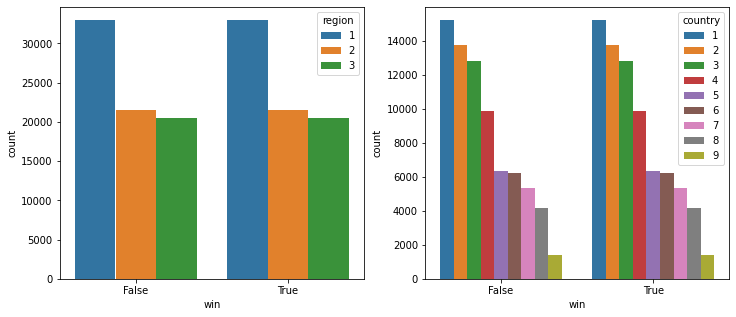

In [3]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.countplot(ax=ax[0], x=pangea['win'], hue=pangea['region'])
sns.countplot(ax=ax[1], x=pangea['win'], hue=pangea['country'])

fig.savefig('graphs/balanced_data.png',bbox_inches='tight')

In [4]:
pangea.head()

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,country,perks.statPerks.defense,perks.statPerks.flex,perks.statPerks.offense,region
0,5,0,0,11205,13,75,Nasus,2,5041.0,5143,...,17,2,0,11,False,4,5002,5002,5007,1
1,6,0,0,9404,12,120,Hecarim,0,115.0,6674,...,18,0,1,8,False,4,5002,5008,5007,1
2,4,0,1,9488,12,887,Gwen,2,3714.0,3714,...,15,0,3,11,False,4,5002,5008,5007,1
3,5,0,1,10052,13,67,Vayne,2,2888.0,2990,...,18,1,0,7,False,4,5002,5008,5005,1
4,10,0,0,8305,11,267,Nami,5,300.0,1152,...,39,3,6,18,False,4,5002,5008,5007,1


# The Problem
## Logistic Regression and Random Forrest Classification:
**The target feature is `win`, a boolean value, making Logistic Regression the perfect model to predict it. Feature selection will be made with Random Forrest Classification to choose the top features for prediction.**


## What are we studying?
**Historically looking at the world championships, multiple countries have won on the world stage. But only one has dominated time and time again, South Korea. Why is this? What accounts for them being better than everyone else? And why are there some countries that don't make it far within these global competitions._The goal of this study, is to find the importance of Region and Country in a teams ability to win at League of Legends_**

## How is this going to be solved?
**If country and region alone are indicators if a team is going to win, then a simple LogReg model could be made using only those two features. If not then incorporating a Random Forrest Classifier for feature selection would be able to more accurately tell what good features for prediction are. Using a new set of selected features a more complex LogReg model could be made to predict the outcome of a team.**

# Mapping the system:
Our logistic regression comes from sklearn.linear_model.LogisticRegression. This model runs on the formula:
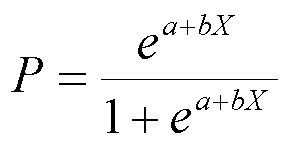
"where P is the probability of a 1 (the proportion of 1s, the mean of Y), e is the base of the natural logarithm (about 2.718) and a and b are the parameters of the model. The value of a yields P when X is zero, and b adjusts how quickly the probability changes with changing X a single unit (we can have standardized and unstandardized b weights in logistic regression, just as in ordinary linear regression). Because the relation between X and P is nonlinear, b does not have a straightforward interpretation in this model as it does in ordinary linear regression. **[1]**"

## Metrics
The metrics that are going to be used to solve this are: ROC curve of a LogisticRegression models using split sets of country, region and lane data. The coefficient of the features from Random Forrest Classification and the CV mean scores using best features from RFC with and without country and origin

All of these in conjunction will accurately tell if region and country are indicators of a teams success.

In [5]:
import statsmodels.api as sm


pt = pangea.drop(columns=['win','championName','lane','role'])
w = pangea['win']

x = sm.add_constant(pt).astype('float')
#x2 = sm.add_constant(pt)
res = sm.OLS(w,x)
summ = res.fit()
print(summ.summary())

# Using an OLS summary we can see that initial pvalue 
# of Region and Country are both .000

# The Logit version of this summary cannot be used because 
# it keeps throwing LinalgErrors,



                            OLS Regression Results                            
Dep. Variable:                    win   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     2318.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:46:46   Log-Likelihood:                -46961.
No. Observations:              150040   AIC:                         9.409e+04
Df Residuals:                  149956   BIC:                         9.492e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [6]:
# These two functions change the lists created below
# Each index holds a different dataframe

# The regions holds individual regions (1-3)
# in the indexes

# The countries holds individual countries (1-9)
# in the indexes

regions = []
countries = []

def seperate_regions(df, regions):
    for i in range(4):
        if i == 0:
            continue
        tmp = df[df['region'] == i]
        regions.append(tmp)

def seperate_countries(df, countries):
    for i in range(10):
        if i == 0:
            continue
        tmp = df[df['country'] == i]
        countries.append(tmp)
        
seperate_regions(pangea,regions)
seperate_countries(pangea,countries)

In [7]:
regions[0].head()

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,country,perks.statPerks.defense,perks.statPerks.flex,perks.statPerks.offense,region
0,5,0,0,11205,13,75,Nasus,2,5041.0,5143,...,17,2,0,11,False,4,5002,5002,5007,1
1,6,0,0,9404,12,120,Hecarim,0,115.0,6674,...,18,0,1,8,False,4,5002,5008,5007,1
2,4,0,1,9488,12,887,Gwen,2,3714.0,3714,...,15,0,3,11,False,4,5002,5008,5007,1
3,5,0,1,10052,13,67,Vayne,2,2888.0,2990,...,18,1,0,7,False,4,5002,5008,5005,1
4,10,0,0,8305,11,267,Nami,5,300.0,1152,...,39,3,6,18,False,4,5002,5008,5007,1


In [8]:
countries[0].head()

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,consumablesPurchased,damageDealtToBuildings,damageDealtToObjectives,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,country,perks.statPerks.defense,perks.statPerks.flex,perks.statPerks.offense,region
129730,3,0,1,18546,18,37225015,Teemo,3,0.0,3482,...,21,0,5,8,False,1,5003,5008,5005,3
129731,4,0,0,14334,15,37290552,Khazix,8,1031.0,21858,...,26,8,3,10,False,1,5002,5008,5008,3
129732,4,0,0,17161,17,37356089,Anivia,8,773.0,773,...,27,1,5,12,False,1,5002,5008,5005,3
129733,4,0,0,15405,16,37421626,Varus,3,1813.0,4081,...,18,2,2,8,False,1,5002,5008,5005,3
129734,9,0,0,13868,15,37487163,Thresh,8,808.0,1288,...,70,4,7,35,False,1,5002,5003,5007,3


## Train Test Splts for each lane

In [9]:
#Pangea
X = pangea.drop(columns=['win','championName','lane','role'],axis=1).values
y = pangea['win'].values
X_train, X_test, y_train,y_test = tts(X,y,shuffle=True)

# TOP
topX = pan_top[['country','region']].values
topy = pan_top['win'].values
topX_train,topX_test, topy_train, topy_test = tts(topX, topy, shuffle=True)

# JNG
jungX = pan_jungle[['country','region']].values
jungy = pan_jungle['win'].values
jungX_train,jungX_test, jungy_train,jungy_test = tts(jungX,jungy, shuffle=True)

# MID
midX = pan_middle[['country','region']].values
midy = pan_middle['win'].values
midX_train,midX_test, midy_train,midy_test = tts(midX, midy, shuffle=True)

# SUP
supX = pan_support[['country','region']].values
supy = pan_support['win'].values
supX_train,supX_test, supy_train,supy_test = tts(supX, supy, shuffle=True)

# ADC
adcX = pan_carry[['country','region']].values
adcy = pan_carry['win'].values
adcX_train, adcX_test, adcy_train,adcy_test = tts(adcX,adcy, shuffle=True)


In [10]:
####
#### In order to use this function the dataframes that are used to make
#### the train_test_split dataframes SHOULD only contain [['country','region']]
####



# This is used to define a Logit Summary
# which would inlcude the pvalues of features
# used in the Logit function
# We can't use this against the entire dataset
# because it raises an 
'''def logitSummary(y,x):
    log = sm.Logit(y,x)
    res = log.fit()
    print(res.summary2())
    
logitSummary(topy,topX)
logitSummary(jungy,jungX)
logitSummary(midy,midX)
logitSummary(supy,supX)
logitSummary(adcy,adcX)'''

'def logitSummary(y,x):\n    log = sm.Logit(y,x)\n    res = log.fit()\n    print(res.summary2())\n    \nlogitSummary(topy,topX)\nlogitSummary(jungy,jungX)\nlogitSummary(midy,midX)\nlogitSummary(supy,supX)\nlogitSummary(adcy,adcX)'

## Pangea ROC


An initial ROC curve should be defined using the entire dataset,
this will give us a control to compare other ROC curves made using
only country and region

<Figure size 216x360 with 0 Axes>

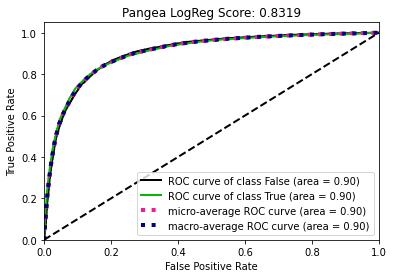

In [11]:
X = pangea.drop(columns=['championName','win','lane','role']).values
y = pangea['win'].values
Xtrain, Xtest, ytrain,ytest = tts(X,y,shuffle=True)

lr = LogisticRegression(max_iter=10000)

plt.figure(figsize=(3,5))
lr.fit(Xtrain,ytrain)
p_probas = lr.predict_proba(Xtest)
skplt.metrics.plot_roc(ytest, p_probas)
plt.title('Pangea LogReg Score: ' + str(round(lr.score(Xtest,ytest),4)))

plt.savefig('graphs/pangea_roc.png', bbox_inches='tight')
plt.show()

## Pangea [['Country', 'Region']] ROC

Comparing this to the initial ROC, we can see that the country and region
don't have much effect when creating a model over the entire dataset

<Figure size 216x360 with 0 Axes>

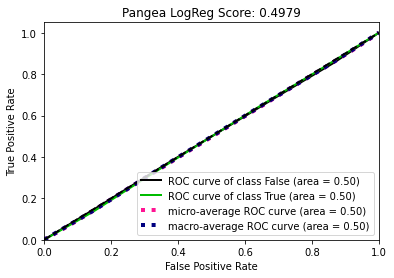

In [12]:
X = pangea[['country','region']].values
y = pangea['win'].values
X_train, X_test, y_train,y_test = tts(X,y,shuffle=True)

plt.figure(figsize=(3,5))
lr.fit(X_train,y_train)
p_probas = lr.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, p_probas)
plt.title('Pangea LogReg Score: ' + str(round(lr.score(X_test,y_test),4)))

plt.savefig('graphs/pangea_country_region_roc.png', bbox_inches='tight')
plt.show()

## Region [['Country', 'Region']] ROC

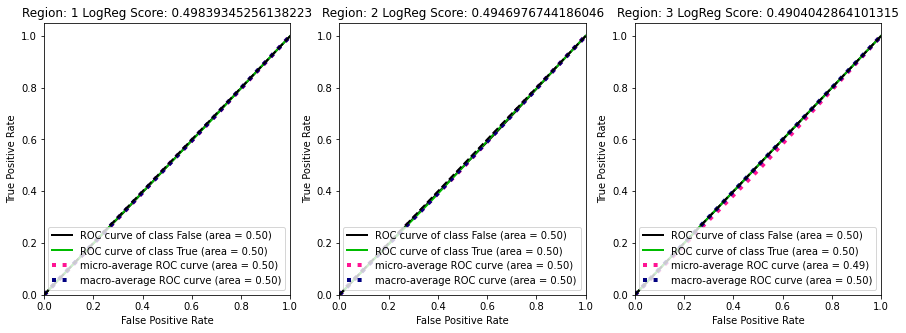

In [13]:
fig, regRoc = plt.subplots(1,3, figsize=(15,5))
for idx, region in enumerate(regions):
    
    regX = region[['country','region']].values
    regy = region['win'].values
    regX_train,regX_test, regy_train, regy_test = tts(regX, regy, shuffle=True)
    
    lr = LogisticRegression(max_iter = 10000)
    lr.fit(regX_train, regy_train)
    
    p_probas = lr.predict_proba(regX_test)
    skplt.metrics.plot_roc(regy_test, p_probas, ax=regRoc[idx])
    regRoc[idx].set_title('Region: ' + str(idx + 1) + ' LogReg Score: ' + str(lr.score(regX_test, regy_test)))
fig.savefig('graphs/region_roc.png', bbox_inches='tight')
    #plt.label('Region: ' + str(idx + 1) + ' LogReg Score: ' + str(lr.score(regX_test, regy_test)))
plt.show()

## Country [['Country', 'Region']] ROC

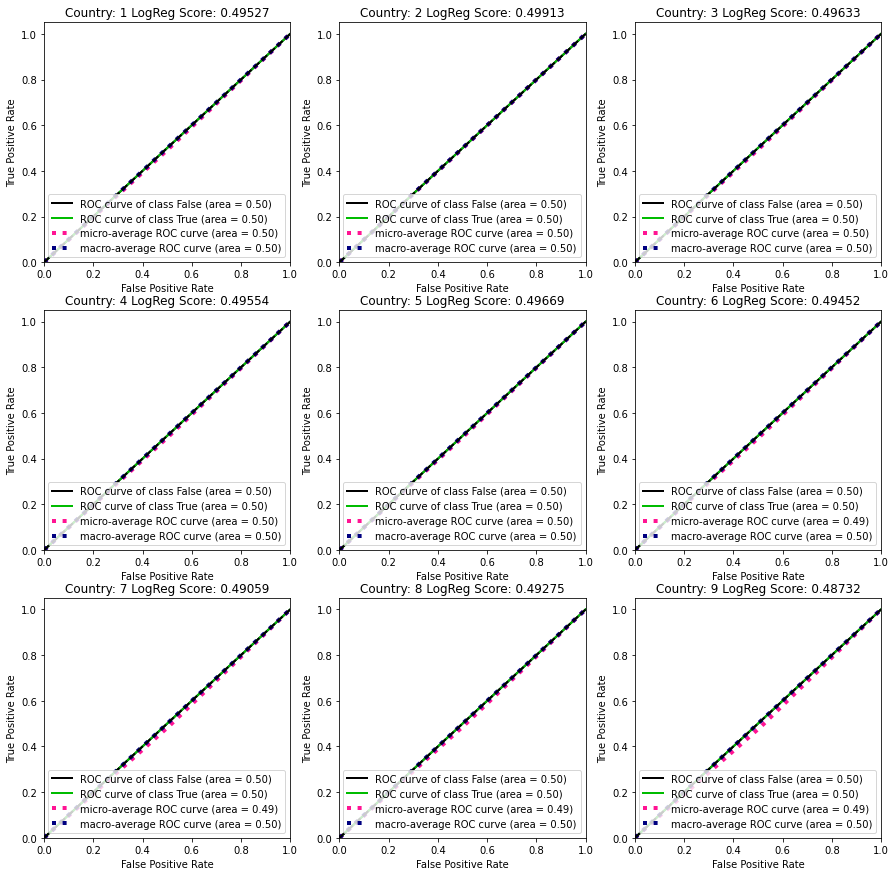

In [14]:
fig, regRoc = plt.subplots(3,3, figsize=(15,15))
col = 0
for idx, con in enumerate(countries):
    conX = con[['country','region']].values
    cony = con['win'].values
    conX_train,conX_test, cony_train, cony_test = tts(conX, cony, shuffle=True)
    
    lr = LogisticRegression(max_iter = 10000)
    lr.fit(conX_train, cony_train)
    
    p_probas = lr.predict_proba(conX_test)
    
    if idx != 0:
        if idx %3 == 0:
            col += 1

        
    skplt.metrics.plot_roc(cony_test, p_probas, ax=regRoc[col][idx % 3])
    regRoc[col][idx%3].set_title('Country: ' + str(idx + 1) + ' LogReg Score: ' + str(round(lr.score(conX_test, cony_test),5)))
plt.show()
fig.savefig('graphs/country_roc.png', bbox_inches='tight')

## Lane [['Country', 'Region']] ROC

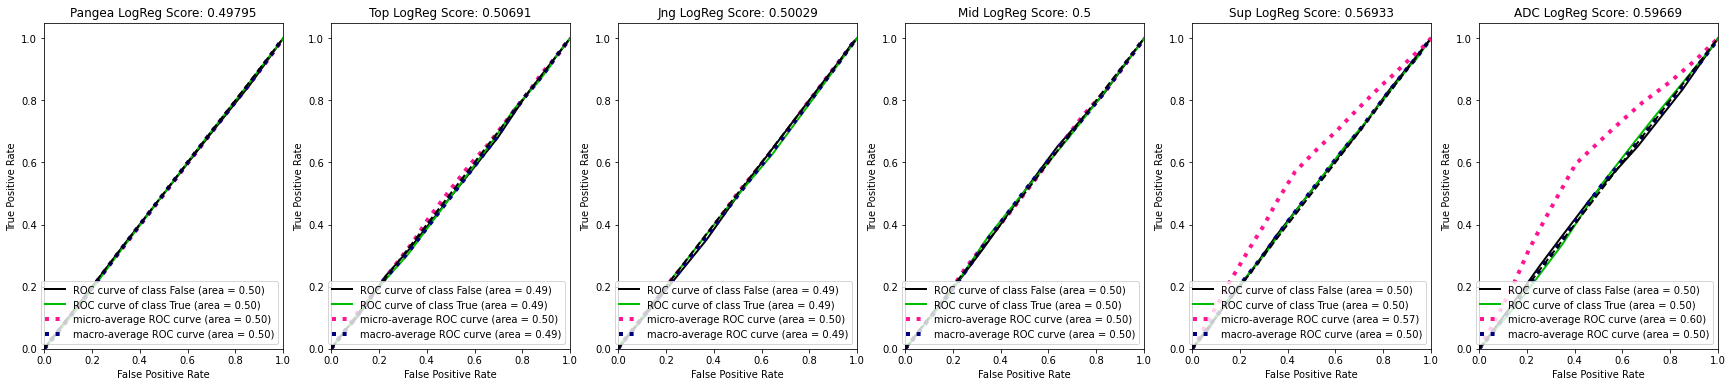

In [15]:
def laneRoc(xTrain,yTrain,xTest,yTest,ax,idx,lane):
    lr = LogisticRegression(max_iter=10000)
    lr.fit(xTrain,yTrain)
    y_pred = lr.predict(xTest)
    predicted_probas = lr.predict_proba(xTest)
    skplt.metrics.plot_roc(yTest, predicted_probas, ax=ax[idx])
    title = lane + ' LogReg Score: ' + str(round(lr.score(xTest,yTest),5))
    ax[idx].set_title(title)
    
fig, ax = plt.subplots(1,6, figsize=(30,6))

laneRoc(X_train,y_train,X_test,y_test,ax,0,'Pangea')
laneRoc(topX_train,topy_train,topX_test,topy_test,ax,1,'Top')
laneRoc(jungX_train,jungy_train,jungX_test,jungy_test,ax,2,'Jng')
laneRoc(midX_train,midy_train,midX_test,midy_test,ax,3,'Mid')
laneRoc(supX_train,supy_train,supX_test,supy_test,ax,4,'Sup')
laneRoc(adcX_train,adcy_train,adcX_test,adcy_test,ax,5,'ADC')

fig.savefig('graphs/lane_country_region_roc.png',bbox_inches='tight')
plt.show()


# Analyzing initial ROC results

## Region
The Region graphs show very little change when compared to each other, with them all indicating torwards the same result that region cannot be used to predict win. At this level of performance the model would be making a 'guess' torwards the outcome.

## Country
Like the region, country also shows results indicating that country cannot be used to predict an outcome.

## Lane
The lanes mostly tell the same story as the other two sets of graphs. Except here the micro-average for both Support and ADC are higher than the rest. But this is not enough to use only country and region aswell.

In [16]:
lanes = [pan_top, pan_jungle, pan_middle, pan_support, pan_carry]
for lane in lanes:
    for i in range(4):
        if i == 0:
            continue
        con = lane[lane['region'] == i].drop(columns=['championName','lane','role','win'])
        win = lane[lane['region']==i]['win']
        clf = LogisticRegression(max_iter=10000)
        clf.fit(con,win)
        print(clf.score(con,win))
    print('\n')

0.8150816084617489
0.8211699164345404
0.8061638280616383




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8563473488822533
0.8515806176003906
0.8423071459014064


0.8370121561100448
0.8402504911591355
0.8234054509693735


0.8453173186171076
0.8463060686015831
0.841889717712447


0.8579253297563156
0.8513869518053618
0.8416324936535833




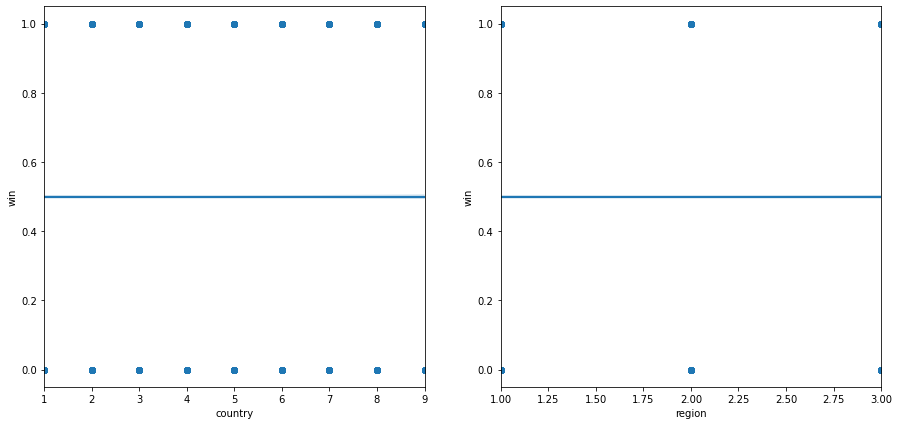

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.regplot(ax = ax[0], data=pangea,x='country',y='win',logistic=True)
sns.regplot(ax = ax[1], data=pangea, x='region',y='win',logistic=True)
fig.savefig('graphs/pangea_country_region_logReg.png',bbox_inches='tight')

In [18]:
'''jung = pangea[pangea['lane']=='JUNGLE'].drop(columns=['championName','lane','role'])
mid  = pangea[pangea['lane']=='MIDDLE'].drop(columns=['championName','lane','role'])
sup  = pangea[pangea['lane']=='BOTTOM'].drop(columns=['championName','lane','role'])


sup = pangea[pangea['lane'] == 'BOTTOM'].drop(columns=['championName','lane','role'])
sup = pan_support[pan_support['kills'] <= 4]
# carry
adc   = pangea[pangea['lane'] == 'BOTTOM'].drop(columns=['championName','lane','role'])
adc   = pan_carry[pan_carry['kills'] > 4]
'''
print("")

# Redefine Train Test Split sets
The first set of train test split was using only the country and region features.
Now the sets will be expanded to encompase all match data.

In [19]:
topX = pan_top.drop(columns=['win','championName','lane','role'],axis=1).values
topy = pan_top['win'].values
topX_train,topX_test, topy_train, topy_test = tts(topX, topy, shuffle=True)

jungX = pan_jungle.drop(columns=['win','championName','lane','role'],axis=1).values
jungy = pan_jungle['win'].values
jungX_train,jungX_test, jungy_train,jungy_test = tts(jungX,jungy, shuffle=True)

midX = pan_middle.drop(columns=['win','championName','lane','role'],axis=1).values
midy = pan_middle['win'].values
midX_train,midX_test, midy_train,midy_test = tts(midX, midy, shuffle=True)

supX = pan_support.drop(columns=['win','championName','lane','role'],axis=1).values
supy = pan_support['win'].values
supX_train,supX_test, supy_train,supy_test = tts(supX, supy, shuffle=True)

adcX = pan_carry.drop(columns=['win','championName','lane','role'],axis=1).values
adcy = pan_carry['win'].values
adcX_train, adcX_test, adcy_train,adcy_test = tts(adcX,adcy, shuffle=True)

# Feature Selection using Random Forrest Classifier

In [20]:
def rfcFeatureSelection(df, xTrain,yTrain,xTest,yTest, region):
    print(region)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(xTrain, yTrain)
    y_pred = clf.predict(xTest)
    #print("Accuracy: ", metrics.accuracy_score(yTest, y_pred))


    #JUNGLE LANE FEATURE SELECTION 
    df = df.drop(columns=['win','championName','lane','role'],axis=1)

    feature_imp = pd.Series(clf.feature_importances_, index=df.columns).sort_values(ascending=False)
    print(feature_imp[:10])
    print('\n\n')
    
    ''' fig = plt.figure(figsize=(30, 30))
    sns.barplot(x=feature_imp, y = feature_imp.index)

    plt.xlabel('Feature Importance Score')
    plt.ylabel('Featuers')
    plt.title('Visualizing Important Features')
    plt.show()'''
    


In [21]:
# Creating regions and dataframes for regions
region1 = pangea[pangea['region']==1]
region1X= pangea[pangea['region']==1].drop(columns=['win','championName','lane','role'],axis=1).values
region1y= pangea[pangea['region']==1]['win'].values
r1X_train,r1X_test, r1y_train, r1y_test = tts(region1X, region1y, shuffle=True)

region2 = pangea[pangea['region']==2]
region2X= pangea[pangea['region']==2].drop(columns=['win','championName','lane','role'],axis=1).values
region2y= pangea[pangea['region']==2]['win'].values
r2X_train,r2X_test, r2y_train, r2y_test = tts(region2X, region2y, shuffle=True)

region3 = pangea[pangea['region']==3]
region3X= pangea[pangea['region']==3].drop(columns=['win','championName','lane','role'],axis=1).values
region3y= pangea[pangea['region']==3]['win'].values
r3X_train,r3X_test, r3y_train, r3y_test = tts(region3X, region3y, shuffle=True)

In [23]:
# I have to redefine these because I changed the value earlier
# when finding regression score of only country and region
X = pangea.drop(columns=['win','championName','lane','role'],axis=1).values
y = pangea['win'].values
X_train, X_test, y_train,y_test = tts(X,y,shuffle=True)

rfcFeatureSelection(region1,r1X_train,r1y_train,r1X_test,r1y_test,'Region 1')
rfcFeatureSelection(region2,r2X_train,r2y_train,r2X_test,r2y_test,'Region 2')
rfcFeatureSelection(region3,r3X_train,r3y_train,r3X_test,r3y_test,'Region 3')
rfcFeatureSelection(pangea,X_train,y_train,X_test,y_test,'Pangea')

Region 1
bountyLevel                0.126010
assists                    0.058793
deaths                     0.057577
totalTimeSpentDead         0.054507
damageDealtToBuildings     0.053876
damageDealtToTurrets       0.049664
damageDealtToObjectives    0.041626
turretKills                0.035229
inhibitorKills             0.026847
totalMinionsKilled         0.018509
dtype: float64



Region 2
bountyLevel                0.105923
deaths                     0.057898
assists                    0.056646
totalTimeSpentDead         0.054335
damageDealtToTurrets       0.050206
damageDealtToBuildings     0.047752
turretKills                0.047529
damageDealtToObjectives    0.037572
inhibitorKills             0.029534
totalMinionsKilled         0.018566
dtype: float64



Region 3
bountyLevel                0.127639
deaths                     0.077772
assists                    0.059739
totalTimeSpentDead         0.048492
damageDealtToBuildings     0.044761
damageDealtToTurrets       0.041796
d

# Interpreting Feature Selection

Feature selection will be done using the regions as the dataframes instead of country because the regions are comprised of the countries. However it is still quite tricky to assume the best features because of the apparent differences between what is more valuable between regions. 

A solution to try, will be creating a list of features that have the highest 10 coefficients from all four sets.

## The final list of features will be
<ul>
    <li>bountyLevel</li>
    <li>deaths</li>
    <li>assists</li>
    <li>totalTimeSpentDead</li>
    <li>damageDealtToBuildings</li>
    <li>damageDealtToTurrets</li>
    <li>damageDealtToObjectives</li>
    <li>turretKills</li>
    <li>inhibitorKills</li>
    <li>champExperience</li>
    <li>country</li>
    <li>region</li>
</ul>

In [24]:
features = ['bountyLevel','deaths','assists','totalTimeSpentDead',
            'damageDealtToBuildings', 'damageDealtToTurrets','turretKills',
            'inhibitorKills', 'champExperience', 'country', 'region','win']

## Final Model
Returning to Logistic Regression and plugging this new set of features
into the model the results should be substantially better than just using
country and region.

In [25]:
def cross_val(x,y,df):
    kfold = KFold(n_splits=5)
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    
    cv_result = cross_val_score(pipe, x,y, cv=kfold,scoring='accuracy')
    cv_predict= cross_val_predict(pipe,x,y,cv=kfold)
    cv_result = cv_result
    return round(cv_result.mean(),4)


In [26]:
def graphROC(X,y,cvMean,flag=False):
    
    lr = LogisticRegression(max_iter=1000)
    

    X_train, X_test, y_train,y_test = tts(X,y,shuffle=True)
    lr.fit(X_train,y_train)

    plt.figure(figsize=(3,5))
    lr.fit(X_train,y_train)
    p_probas = lr.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, p_probas)

    if flag:
        plt.title('w/Country and Region \nLogReg Score: ' + str(round(lr.score(X_test,y_test),4)) + ' \nCV Mean Score: ' +str(cvMean))
        plt.savefig('graphs/Final Model with country and region.png', bbox_inches='tight')
    else:
        plt.title('w/o Country and Region \nLogReg Score: ' + str(round(lr.score(X_test,y_test),4)) + ' \nCV Mean Score: ' +str(cvMean))
        plt.savefig('graphs/Final Model without country and region.png', bbox_inches='tight')

    plt.show()

<Figure size 216x360 with 0 Axes>

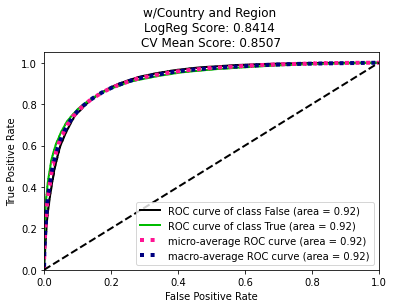

In [27]:
# Final Graph 1
pan_final = pangea[features]
pfX = pan_final.drop(columns=['win']).values
pfy = pan_final['win'].values
cross_val(pfX,pfy, pan_final)
graphROC(pfX,pfy,cross_val(pfX,pfy,pan_final),1)

<Figure size 216x360 with 0 Axes>

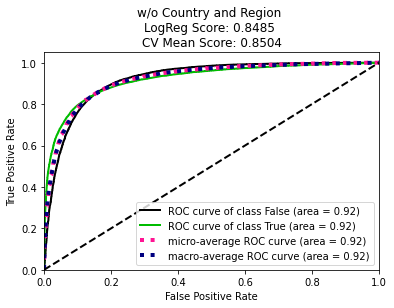

In [28]:
# Final Graph 2
pan_final = pangea[features].drop(columns=['country','region'])
pfX = pan_final.drop(columns=['win']).values
pfy = pan_final['win'].values
graphROC(pfX,pfy, cross_val(pfX,pfy,pan_final))

# Results and Metrics

## Metrics
What is being used to determine the significance of the feature are the final CV scores. The reason being is that if the two features had a significant effect it would be able to be viewed and greatly measured over 10 folds on a moderate dataset.

However from what we can see, the two features in question have an insignificant effect and cannot be used accurately to predict whether a team will be successfull or not. Using this type of metric, a final conclusion was able to be made.

## Graph 1
Graph 1 is made up of a dataframe containing the best features that was received from the Random Forrest Classifier as well as country and region. The dataframe was fit to a LogisticRegression model which had a score of **.8387** then used again to find the mean score from a cross fold validation with 10 folds and produced a score of **.8507**

## Graph 2
Graph 2 is the same dataframe that was used in Graph 1 but with country and region dropped. The Logistic Regression came back with a score of **.8472** and the cross fold validation had mean score of **.8504**

# Conclussion
The results show no drastic change in any direction. If the region and country was important for a teams success the accuracy of the models without them should decrease. But they are staying the same, in fact, the first graphs made with only the country and region told us from the start that it was not a good measurement, that the origin has no significance to a team.

Aside from answering the initial hypothesis, the most important information came from the RFC feature selection. At this stage, it was obvious that the region seperates different play-style. This can be inferred because what is important to predict a win changes dependent on what region is being viewed.

Finaly,props has to be given to the South Korean proffessional teams. The initial hypothesis was looking for evidence that origin is a significant factor in a teams success, and as has been realized, it is not even worth placing in a model. The one aspect that region helps is distinguishing playstyles from one another. All evedince supporting the fact that success comes from skill, rather than a teams origin.

# REFERENCES
[1] http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html image of logistic regression formula and defenition